In [1]:
!pip install folium geopy pyproj requests geopandas xlsxwriter ipywidgets
#En tu directorio de trabajo debes tener los archivos PISCO TMAX.nc TMIN.nc Evapotranspiracion.nc y Precipitacion.nc
#Este es el mío:
%cd /content/drive/MyDrive/PISCO

/content/drive/MyDrive/PISCO


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import io
import base64
from pyproj import Transformer
from geopy.distance import geodesic
import requests

# Cargar los datasets de temperatura
try:
    PISCO_tmax_daily = xr.open_dataset("TMAX.nc")
    PISCO_tmax_daily = PISCO_tmax_daily.rename({"X":"longitude","Y":"latitude","T":"time"})
except FileNotFoundError:
    print("Archivo 'TMAX.nc' no encontrado. Por favor, revisa su ubicación.")

try:
    PISCO_tmin_daily = xr.open_dataset("TMIN.nc")
    PISCO_tmin_daily = PISCO_tmin_daily.rename({"X":"longitude","Y":"latitude","T":"time"})
except FileNotFoundError:
    print("Archivo 'TMIN.nc' no encontrado. Por favor, revisa su ubicación.")

# Cargar el dataset de evapotranspiración
try:
    ET_daily = xr.open_dataset("Evapotranspiracion.nc")
    ET_daily = ET_daily.rename({"X": "longitude", "Y": "latitude", "T": "time"})
except FileNotFoundError:
    print("Archivo 'Evapotranspiracion.nc' no encontrado. Por favor, revisa su ubicación.")

# Cargar el dataset de precipitación
try:
    PISCO_pp_daily = xr.open_dataset("Precipitacion.nc", decode_times=False)
    PISCO_pp_daily = PISCO_pp_daily.rename({"X":"longitude", "Y":"latitude","T":"time"})
    PISCO_pp_daily["time"] = pd.date_range(start="1981-01-01T12:00:00.000000000",
                                           freq="1D",
                                           periods=13149)
except FileNotFoundError:
    print("Archivo 'Precipitacion.nc' no encontrado. Por favor, revisa su ubicación.")

# Determinar el rango de fechas disponibles
try:
    all_times = PISCO_pp_daily['time'].values
    min_date = pd.to_datetime(all_times.min())
    max_date = pd.to_datetime(all_times.max())
except NameError:
    min_date = pd.to_datetime("1981-01-01")
    max_date = pd.to_datetime("2020-12-31")

# Widgets interactivos

start_date = widgets.DatePicker(
    description='Fecha Inicio',
    value=min_date,
    disabled=False
)

end_date = widgets.DatePicker(
    description='Fecha Fin',
    value=max_date,
    disabled=False
)

variables_options = ['Tmax', 'Tmin', 'PET', 'Prec']
variables_select = widgets.SelectMultiple(
    options=variables_options,
    value=variables_options,
    description='Variables',
    disabled=False
)

frequency_select = widgets.Dropdown(
    options=['Diario', 'Mensual', 'Anual'],
    value='Diario',
    description='Frecuencia',
    disabled=False,
)

format_options = ['Normal', 'Tetis']
format_select = widgets.Dropdown(
    options=format_options,
    value='Normal',
    description='Formato:',
    disabled=False,
)

lat_input = widgets.FloatText(description='Latitud', value=0.0)
lon_input = widgets.FloatText(description='Longitud', value=0.0)
localidad_input = widgets.Text(description='Localidad', placeholder='Nombre')
add_button = widgets.Button(description='Agregar Localidad', button_style='primary')
localidades_output = widgets.Output()

upload_button = widgets.FileUpload(
    accept='.xlsx',
    multiple=False
)
upload_output = widgets.Output()

generate_button = widgets.Button(
    description='Generar y Descargar Datos',
    button_style='success',
    icon='download'
)

output = widgets.Output()
localidades = {}

# Función para descargar automáticamente el archivo Excel
def trigger_download(filename):
    try:
        with open(filename, "rb") as f:
            data = f.read()
        b64 = base64.b64encode(data).decode()
        display(HTML(f"""
            <script>
                var link = document.createElement('a');
                link.href = "data:application/octet-stream;base64,{b64}";
                link.download = "{filename}";
                document.body.appendChild(link);
                link.click();
                document.body.removeChild(link);
            </script>
        """))
    except Exception as e:
        print(f"Error al intentar descargar el archivo: {e}")

def actualizar_opciones_localidades():
    # Si tienes widgets adicionales que dependan de las localidades, actualiza aquí.
    pass

def agregar_localidad(event):
    nombre = localidad_input.value.strip()
    lat = lat_input.value
    lon = lon_input.value

    if not nombre:
        with localidades_output:
            localidades_output.clear_output()
            print("Por favor ingresa un nombre para la localidad.")
        return

    nueva_coord = (lat, lon)
    for existing_nombre, coords in localidades.items():
        existente_coord = (coords['lat'], coords['lon'])
        distancia = geodesic(nueva_coord, existente_coord).kilometers
        if distancia < 10:
            with localidades_output:
                localidades_output.clear_output()
                print(f"Advertencia: La localidad '{nombre}' está a {distancia:.2f} km de '{existing_nombre}', menor que la resolución de PISCO (10 km).")
            break
    else:
        localidades[nombre] = {'lat': lat, 'lon': lon}
        with localidades_output:
            localidades_output.clear_output()
            print("Localidades actuales:")
            for n, coords in localidades.items():
                print(f"- {n}: Lat={coords['lat']}, Lon={coords['lon']}")
        actualizar_opciones_localidades()

def handle_upload(change):
    for filename, file_info in upload_button.value.items():
        content = file_info['content']
        with upload_output:
            upload_output.clear_output()
            try:
                df = pd.read_excel(io.BytesIO(content))
                # Limpieza de nombres de columnas
                df.columns = df.columns.str.strip().str.capitalize()

                required_columns_latlon = {'Nombre', 'Latitud', 'Longitud'}
                required_columns_utm = {'Nombre', 'X', 'Y', 'Zona', 'Hemisferio'}

                if required_columns_latlon.issubset(set(df.columns)):
                    for index, row in df.iterrows():
                        nombre = row['Nombre']
                        lat = row['Latitud']
                        lon = row['Longitud']

                        nueva_coord = (lat, lon)
                        close = False
                        for existing_nombre, coords in localidades.items():
                            existente_coord = (coords['lat'], coords['lon'])
                            distancia = geodesic(nueva_coord, existente_coord).kilometers
                            if distancia < 10:
                                close = True
                                break
                        if not close:
                            localidades[nombre] = {'lat': lat, 'lon': lon}
                elif required_columns_utm.issubset(set(df.columns)):
                    for index, row in df.iterrows():
                        nombre = row['Nombre']
                        x = row['X']
                        y = row['Y']
                        zona = int(row['Zona'])
                        hemisferio = row['Hemisferio'].strip().upper()

                        if hemisferio == 'NORTE':
                            epsg_code = f"326{zona:02d}"
                        elif hemisferio == 'SUR':
                            epsg_code = f"327{zona:02d}"
                        else:
                            continue

                        transformer = Transformer.from_crs(f"epsg:{epsg_code}", "epsg:4326", always_xy=True)
                        lon, lat = transformer.transform(x, y)

                        nueva_coord = (lat, lon)
                        close = False
                        for existing_nombre, coords in localidades.items():
                            existente_coord = (coords['lat'], coords['lon'])
                            distancia = geodesic(nueva_coord, existente_coord).kilometers
                            if distancia < 10:
                                close = True
                                break
                        if not close:
                            localidades[nombre] = {'lat': lat, 'lon': lon}
                else:
                    print("El archivo Excel no tiene las columnas requeridas.")
                    return

                print("Localidades cargadas exitosamente desde el archivo Excel.")
                print("Localidades actuales:")
                for n, coords in localidades.items():
                    print(f"- {n}: Lat={coords['lat']}, Lon={coords['lon']}")
                actualizar_opciones_localidades()
            except Exception as e:
                print(f"Error al procesar el archivo: {e}")

def generar_datos(event):
    if not localidades:
        with output:
            output.clear_output()
            print("Por favor agrega al menos una localidad antes de generar datos.")
        return

    start = start_date.value
    end = end_date.value
    if start and end and start > end:
        with output:
            output.clear_output()
            print("La fecha de inicio no puede ser posterior a la fecha de fin.")
        return

    if start and end:
        PISCO_tmax = PISCO_tmax_daily.sel(time=slice(str(start), str(end)))
        PISCO_tmin = PISCO_tmin_daily.sel(time=slice(str(start), str(end)))
        ET = ET_daily.sel(time=slice(str(start), str(end)))
        PISCO_pp = PISCO_pp_daily.sel(time=slice(str(start), str(end)))
    else:
        PISCO_tmax = PISCO_tmax_daily
        PISCO_tmin = PISCO_tmin_daily
        ET = ET_daily
        PISCO_pp = PISCO_pp_daily

    selected_vars = variables_select.value
    available_vars = {'Tmax': PISCO_tmax, 'Tmin': PISCO_tmin, 'PET': ET, 'Prec': PISCO_pp}

    if not selected_vars:
        with output:
            output.clear_output()
            print("Por favor selecciona al menos una variable.")
        return

    freq = frequency_select.value
    formato_seleccionado = format_select.value

    df_total = pd.DataFrame()
    localidades_info = []

    for nombre, coords in localidades.items():
        data_selected = {}
        for var in selected_vars:
            dataset = available_vars[var]
            data = dataset.sel(longitude=coords['lon'], latitude=coords['lat'], method='nearest')
            df = data.to_dataframe().reset_index()
            df = df.rename(columns={var.lower(): var})
            data_selected[var] = df[['time', var]]

        df_localidad = None
        for var, df_var in data_selected.items():
            if df_localidad is None:
                df_localidad = df_var
            else:
                df_localidad = pd.merge(df_localidad, df_var, on="time", how="outer")

        df_localidad["time"] = pd.to_datetime(df_localidad["time"])

        if freq == 'Diario':
            df_agg = df_localidad.copy()
        else:
            if freq == 'Mensual':
                group_by = df_localidad['time'].dt.to_period('M')
            elif freq == 'Anual':
                group_by = df_localidad['time'].dt.to_period('Y')

            agg_dict = {}
            for var in selected_vars:
                if var == 'Prec':
                    agg_dict[var] = 'sum'
                else:
                    agg_dict[var] = 'mean'

            df_agg = df_localidad.groupby(group_by).agg(agg_dict).reset_index()
            df_agg['time'] = df_agg['time'].dt.to_timestamp()

        df_agg['Localidad'] = nombre
        df_total = pd.concat([df_total, df_agg], ignore_index=True)

    if formato_seleccionado == 'Tetis':
        try:
            df_tetis = df_total.pivot(index='time', columns='Localidad')
            df_tetis.columns = [f"{localidad}_{var}" for var, localidad in df_tetis.columns]
            df_tetis = df_tetis.reset_index()

            # Reordenamiento según la lógica TETIS
            # 1. Orden de variables a usar (respetando [Tmax, Tmin, PET, Prec] pero
            #    filtrando solo las que están en selected_vars).
            orden_completo = ['Tmax', 'Tmin', 'PET', 'Prec']
            orden_variables = [v for v in orden_completo if v in selected_vars]

            # 2. Orden de localidades según el orden de inserción en el diccionario
            orden_localidades = list(localidades.keys())  # o sorted(localidades.keys()) si quieres alfabético

            # 3. Construir la lista final de columnas
            columnas_deseadas = ['time']
            for loc in orden_localidades:
                for var in orden_variables:
                    col = f"{loc}_{var}"
                    columnas_deseadas.append(col)

            # 4. Filtrar para no incluir columnas inexistentes
            columnas_finales = [c for c in columnas_deseadas if c in df_tetis.columns]

            df_tetis = df_tetis[columnas_finales]
            df_final = df_tetis

        except Exception as e:
            with output:
                output.clear_output()
                print(f"Error al reestructurar los datos para el formato Tetis: {e}")
            return
    else:
        df_final = df_total

    for nombre, coords in localidades.items():
        lat = coords['lat']
        lon = coords['lon']

        zona_utm = int((lon + 180) / 6) + 1
        if lat >= 0:
            epsg_code = f"326{zona_utm:02d}"
        else:
            epsg_code = f"327{zona_utm:02d}"

        transformer = Transformer.from_crs("epsg:4326", f"epsg:{epsg_code}", always_xy=True)
        x, y = transformer.transform(lon, lat)

        api_url = "https://api.open-elevation.com/api/v1/lookup"
        params = {"locations": f"{lat},{lon}"}
        try:
            response = requests.get(api_url, params=params)
            if response.status_code == 200:
                elevation = response.json()['results'][0]['elevation']
            else:
                elevation = None
        except:
            elevation = None

        localidades_info.append({
            'Nombre': nombre,
            'Latitud': lat,
            'Longitud': lon,
            'Posición X': x,
            'Posición Y': y,
            'Altura (Z)': elevation
        })

    df_localidades_info = pd.DataFrame(localidades_info)

    output.clear_output()

    filename = "datos_localidades.xlsx"
    try:
        with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
            df_final.to_excel(writer, index=False, sheet_name='Datos')
            df_localidades_info.to_excel(writer, index=False, sheet_name='Información_Localidades')
        with output:
            output.clear_output()
            if formato_seleccionado == 'Normal':
                print(f"Archivo '{filename}' (Formato Normal) ha sido guardado en el directorio actual.")
            else:
                print(f"Archivo '{filename}' (Formato Tetis) ha sido guardado en el directorio actual.")
            trigger_download(filename)
    except Exception as e:
        with output:
            output.clear_output()
            print(f"Error al generar el archivo Excel: {e}")

# Vincular funciones a eventos
add_button.on_click(agregar_localidad)
upload_button.observe(handle_upload, names='value')
generate_button.on_click(generar_datos)

# Construir la interfaz
localidad_widgets = widgets.VBox([
    localidad_input, lat_input, lon_input, add_button, localidades_output
])
upload_widgets = widgets.VBox([
    widgets.Label("O carga un archivo Excel con las localidades:"),
    upload_button,
    upload_output
])

inputs = widgets.HBox([localidad_widgets, upload_widgets])

selection_widgets = widgets.VBox([
    widgets.HBox([start_date, end_date]),
    widgets.HBox([widgets.Label("Selecciona Variables:"), variables_select]),
    widgets.HBox([widgets.Label("Selecciona Frecuencia:"), frequency_select]),
    widgets.HBox([widgets.Label("Selecciona Formato:"), format_select])
])

display(inputs, selection_widgets, generate_button, output)


Button(button_style='success', description='Generar y Descargar Datos', icon='download', style=ButtonStyle())

Output()

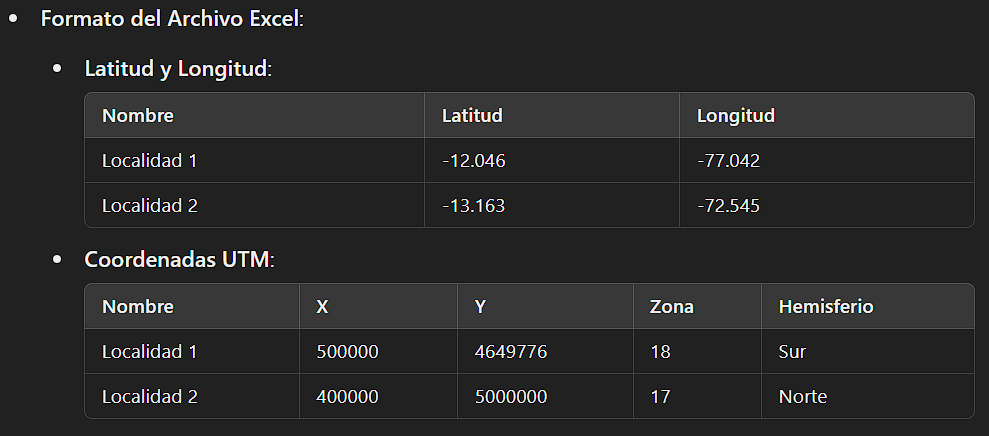